<a href="https://colab.research.google.com/github/Ankit-exe/AWT/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

Lets explore a an example Pytorch end-toend workflow

In [ ]:
what_were_covering = {1:"data (prepare and load)",
                      2:"build model",
                      3:"fitting the model to data(training)",
                      4:"making predictions and evaluatuiing a model(inference)",
                      5:"saving and loading model",
                      6:"putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data(training)',
 4: 'making predictions and evaluatuiing a model(inference)',
 5: 'saving and loading model',
 6: 'putting it all together'}

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt


# Check pytorch version
torch.__version__

'2.6.0+cu124'

## 1. Data (preparing and loading)

Machine learining is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representaions.

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start =0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Splitting data into training and testing set

train_split = int(0.8 * len(X))
X_train , y_train = X[:train_split] , y[:train_split]
X_test , y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

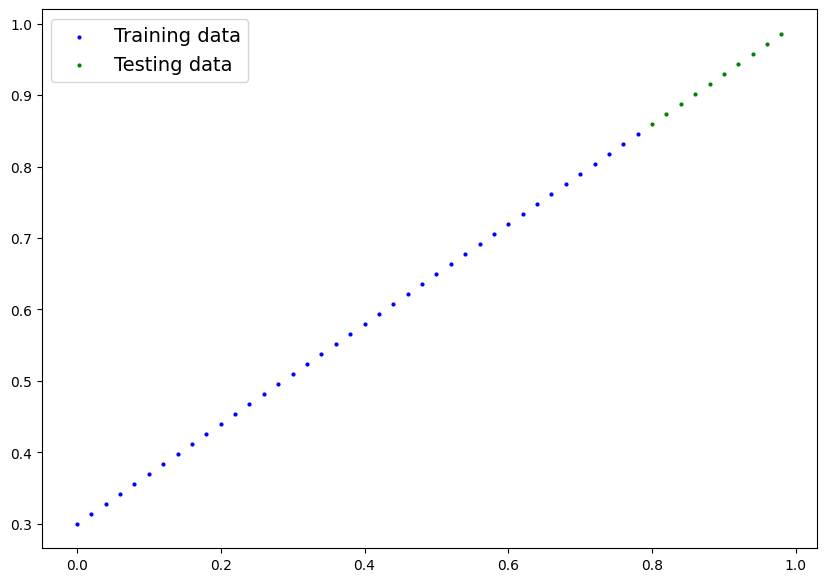

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):


  """
  Plots training data, test data and compare the predictions.

  """

  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels , c ="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels , c ="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r" , label="Predictions")

  plt.legend(prop={"size":14});

plot_predictions()

## 2. Build model
 Our first pytorch model


In [ ]:
# Create linear regression model class

class LinearRegressionModel(nn.Module): #Almost everything in Pytorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad= True,
                                            dtype = torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad =True,
                                         dtype =torch.float))

  def forward(self,x:torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### Pytorch model building essentials
* torch.nn - contains the building for computational graph
* torch.nn.Parameter - what parameters should our model try and learn
* torch.nn.Module - The base class for all neural network modules, If you subclass it, you should overwrite forward()
* torch.optim - this where the optimizer in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses requires you to overrides


## Checking the content of our PyTorch model

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()
# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our models predictive power, lets see how well it predicts `y_test` based on  `X_test`.

When we pass data through our model, its going to runit through 'forward()' method


In [ ]:
X_test , y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [ ]:
# Making predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

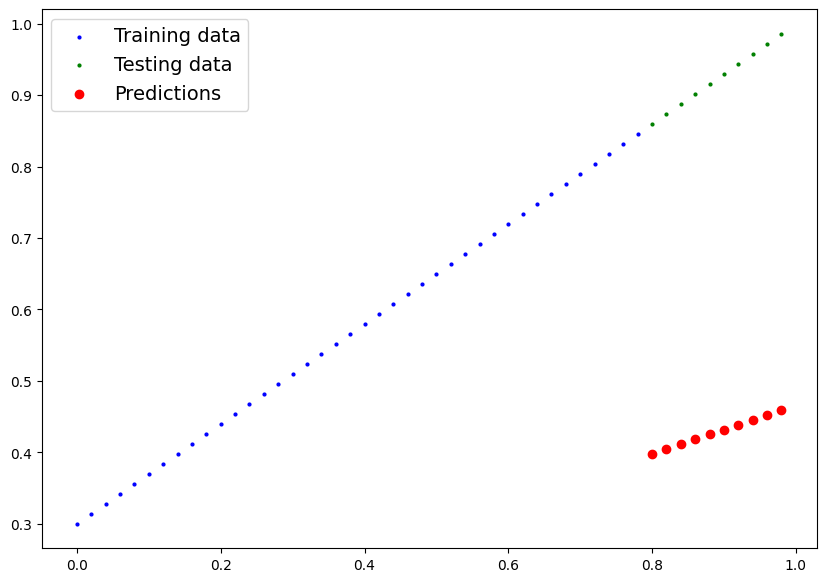

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train Model

The world idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

One way to measure how poor or how wrong your models is by using LossFunctions

Note : Loss function may also be called cost function or criterion in different areas. FOr our case, we are goinf to refer it as a loss function.

* **Loss function:** A function measures how wrong is our model from the original data (lower is better)

* **Optimizer:** Takes into account the loss of a model and adjusts the models parameters (e.g. weight & bias)

And specifically for PyTorch,we need:
* A training loop
* A testing loop


In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an Optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01) # lr - learning rate = most imp learing hyperparameter you can set

***Q:*** Which loss function optimizer should i use?
***A:*** This will be problem specific. But with experience we will get there

for e.g For Regression Problem, aloss function of `nn.L1Loss()` and oprimizer like `torch.optim.SGD()` will suffice.

But for a classification problem like classifying whether a photo os of a dog or a cat youll likelt want to use a loss function of `nn.BCWLoss()` (binary cross entropy loss)

## Building a trainig loop (and a testing loop) in PyTorch

A Couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (forward propagation)
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to loss
5. Optimizer step


In [ ]:
# An epoch is one loop through the data(this is a hyperparameter beacuse we set it)
epochs = 1

### Training
# 0. Loop through the data
for epochs in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in Pytorch set all the parameters that require gradients to require gradient

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimize zero grad
  optimizer.zero_grad()

  # 4. Perform backward propagation on the loss wrt the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so we have to zero them in step 3 for the next iteration of the loop

  model_0.eval() # turns off gradient tracking


